In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transforms = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms)

test_dataset = datasets.MNIST(
    './data',
    train=False,
    download=True,
    transform=transforms
)

In [3]:
class Net(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, LATENT_SIZE):
        super(Net, self).__init__()
        self.en1 = nn.Linear(INPUT_SIZE, HIDDEN_SIZE)
        self.en2_mu = nn.Linear(HIDDEN_SIZE, LATENT_SIZE)
        self.en2_sigma = nn.Linear(HIDDEN_SIZE, LATENT_SIZE)

        self.de1 = nn.Linear(LATENT_SIZE, HIDDEN_SIZE)
        self.de2 = nn.Linear(HIDDEN_SIZE, INPUT_SIZE) 

        self.mu = torch.empty(LATENT_SIZE)
        self.sigma = torch.empty(LATENT_SIZE)

    def encoder(self,x):
        x = torch.tanh(self.en1(x))  
        mu = torch.tanh(self.en2_mu(x))
        sigma = torch.tanh(self.en2_sigma(x)) 
        return mu, sigma

    def decoder(self,x):
        x = torch.tanh(self.de1(x))
        x = torch.sigmoid(self.de2(x))
        return x

    def forward(self,x):
        self.mu, self.sigma = self.encoder(x)
    
        # reparamatrization
        x = self.reparametrize(self.mu, self.sigma)
        
        # Decoder
        x = self.decoder(x)
        return x

    def reparametrize(self, mu, sigma):
    
        epsilon = torch.randn_like(sigma)
        sample = epsilon.mul(sigma) + mu
        return sample 

    def VAE(self):
        return self.mu, self.sigma

In [4]:
def train(SAVE_MODEL = False, LOG_DATA = False):
    train_loss = 0
    loss = 0
    
    for i, data in enumerate(train_loader):
        # get data
        input, _ = data
        input = input.view(input.shape[0],-1)
        input = input.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        output = model(input)    

        recon_loss = F.binary_cross_entropy(output, input, size_average=False)
        mu, sigma = model.VAE()

        kl_loss = 0.5 * torch.sum(torch.exp(sigma) + mu**2 - 1. - sigma)

        loss = recon_loss + kl_loss
        # print("kl_loss: ", kl_loss  )
        # print("recon_loss: ", recon_loss  )

        loss.backward()
        train_loss += 0.001*loss.item()

        optimizer.step()
    
    if LOG_DATA:
        writer.add_scalar('training loss',
                       train_loss/ 100,
                       epoch)
  
    print("Episode: ", epoch, "loss: ", train_loss)

    if epoch%10 == 0 and SAVE_MODEL:
        torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}, 
            'model_best.pth.tar')
        
    return train_loss

def test():
    SAMPLES = 16
    test_sampler = DataLoader(test_dataset, batch_size=SAMPLES, shuffle=True)
    iterator = iter(test_sampler)
    images, labels = iterator.next()
    imshow(make_grid(images.cpu(),nrow=SAMPLES))
        
    inputs = images.view(images.shape[0],-1)
    inputs = inputs.to(device)
    
    outputs = model(inputs)
    outputs = outputs.view(SAMPLES,1,28,28)
    
    imshow(make_grid(outputs.cpu(),nrow=SAMPLES))    
    
    # Gaussian sampling
    z = torch.randn(16, LATENT_SIZE).to(device)

    # run only the decoder
    recon_img = model.decoder(z)
    img = recon_img.view(SAMPLES, 1, 28, 28).data
    imshow(make_grid(img.cpu(),nrow=SAMPLES)) 

def imshow(img):
    npimg = img.detach().numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    
    plt.imshow(npimg)
    plt.show()    

In [6]:
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPISODES = 1
INPUT_SIZE = 28*28
HIDDEN_SIZE = 256
LATENT_SIZE = 32
SAVE_MODEL = False
LOG_DATA = False
LOAD_MODEL = False

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = Net(INPUT_SIZE, HIDDEN_SIZE, LATENT_SIZE).cuda()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

if LOAD_MODEL:
    checkpoint = torch.load('model_best.pth.tar')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_ = checkpoint['epoch']
    loss_ = checkpoint['loss']

model.train()

for epoch in range(EPISODES):
    train_loss = train(SAVE_MODEL, LOG_DATA)

# test()

Episode:  0 loss:  10879.476178710946


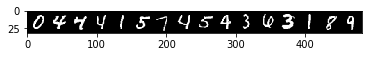

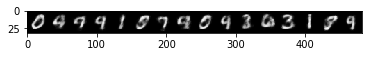

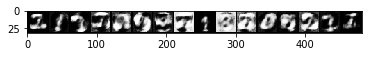